In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

In [8]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [9]:
domain = domains.domains['Water_Watch']

### import libraries for validation

In [10]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [11]:
verif_dset = 'ERA'
quantile = 'quartile'
varname = 'TPRATE'
period = 'monthly'
step = 1

In [12]:
# Parameters
step = 5
period = "seasonal"


In [13]:
opath_mme_probabilities = CWD.parents[1].joinpath(f"outputs/C3S_MME_{quantile}_probabilities")

In [14]:
lfiles = list(opath_mme_probabilities.glob("*"))

In [15]:
lfiles

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_quartile_probabilities/C3S_MME_monthly_quartile_probabilities.zarr'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_quartile_probabilities/C3S_MME_seasonal_quartile_probabilities.zarr')]

In [16]:
dset_mme = xr.open_zarr(opath_mme_probabilities.joinpath(f"C3S_MME_{period}_{quantile}_probabilities.zarr"))

In [17]:
dset_mme

,Array,Chunk
Bytes,2.02 GiB,1.76 MiB
Shape,"(8, 288, 4, 3, 81, 121)","(8, 288, 1, 1, 10, 10)"
Count,1405 Tasks,1404 Chunks
Type,float64,numpy.ndarray


### take the leadtime in the GCM

In [18]:
dset_mme = dset_mme.sel(step=step)

In [19]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 5
    time     datetime64[ns] 1993-01-01

In [20]:
dset_mme['time'] = dset_mme.indexes['time'] + pd.offsets.MonthBegin(step)

In [21]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-06-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 5
    time     datetime64[ns] 1993-06-01

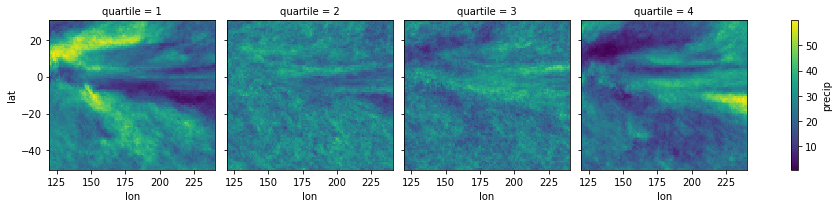

In [22]:
dset_mme.sel(GCM='MME').isel(time=0)['precip'].plot(x='lon', y='lat', col=quantile)

### most likely quartile 

In [23]:
dset_mme = dset_mme.idxmax(dim=quantile)

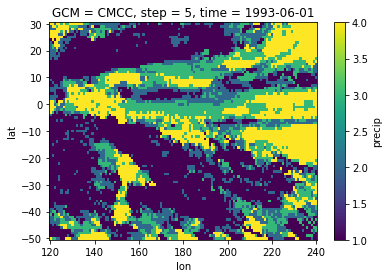

In [24]:
dset_mme['precip'][0,0,:,:].plot()

### Now reads in the verification dataset 

In [25]:
opath_verif_categories = CWD.parents[1].joinpath(f"outputs/{verif_dset}_{quantile}_categories")

In [26]:
verif_quantile_categories = xr.open_zarr(opath_verif_categories.joinpath(f"{verif_dset}_{quantile}_{period}_categories.zarr"))

### merge the datasets 

In [27]:
dset_mme, verif_quantile_categories = xr.align(dset_mme, verif_quantile_categories)

In [28]:
dset_merge = dset_mme.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories.rename_vars({'precip':'verif'}))

In [29]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, time: 283, GCM: 8, lon: 121)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * time     (time) datetime64[ns] 1993-06-01 1993-07-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 5
    month    (time) int64 dask.array<chunksize=(283,), meta=np.ndarray>
Data variables:
    gcm      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 283, 5, 10), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

### rechunk 

In [30]:
dset_merge = dset_merge.chunk({'time':-1, 'lat':10, 'lon':10},)

In [31]:
dset_merge.nbytes / 1e9

0.150401148

In [32]:
with ProgressBar(): 
    dset_merge = dset_merge.compute()

[########################################] | 100% Completed | 22.8s


In [33]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, time: 283, GCM: 8, lon: 121)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * time     (time) datetime64[ns] 1993-06-01 1993-07-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 5
    month    (time) int64 6 7 8 9 10 11 12 1 2 3 4 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    gcm      (GCM, time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
    verif    (time, lat, lon) int64 3 3 3 3 3 3 3 3 3 3 ... 4 4 4 2 2 4 4 3 3 3

In [34]:
dset = dset_merge.sel(GCM='ECMWF')

In [35]:
fnegatives = verification.false_negatives(dset)

In [36]:
fpositives = verification.false_positives(dset)

In [37]:
tpositives = verification.true_positives(dset)

In [38]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [39]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

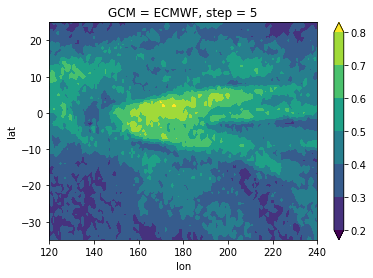

In [40]:
precision.plot.contourf(levels=np.arange(0.2, 0.9,  0.1))

In [41]:
dset = dset_merge.sel(GCM='MME')

In [42]:
class_value = 1

In [43]:
class_dict = {}
class_dict[1] = ['lower', '< 1st quartile']
class_dict[2] = ['mid-lower', 'between 1st quartile and median']
class_dict[3] = ['mid-upper', 'between median and 3rd quartile']
class_dict[4] = ['upper', '> 3rd quartile']

In [44]:
fnegatives = verification.false_negatives(dset, class_value=class_value)

In [45]:
fpositives = verification.false_positives(dset, class_value=class_value)

In [46]:
tpositives = verification.true_positives(dset, class_value=class_value)

In [47]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [48]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

In [49]:
cbar_kwargs = dict(shrink=0.8, orientation='vertical', drawedges=True, pad=0.01)

In [50]:
F1_Score = 2*(recall * precision) / (recall + precision)

In [51]:
import palettable

In [52]:
cmap = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

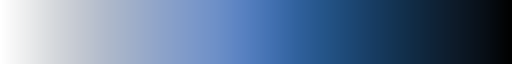

In [53]:
cmap

In [54]:
if period == 'seasonal': 
    period_label = 'season'
    lead = step - 2 
elif period == 'monthly': 
    period_label = 'month'
    lead = step

In [55]:
# f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# axes = axes.flatten()

# ax = axes[0]

# precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) precision, 1 season ahead")

# ax = axes[1]

# recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) recall, 1 season ahead")

# ax = axes[2]

# F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) F1 score, 1 season ahead")

# f.savefig(f'./{category_name}_precision_recall_F1score.png', dpi=200, bbox_inches='tight', facecolor='w')

Text(0.5, 1.0, 'C3S MME, lower category (< 1st quartile) F1 score, 3 season ahead')

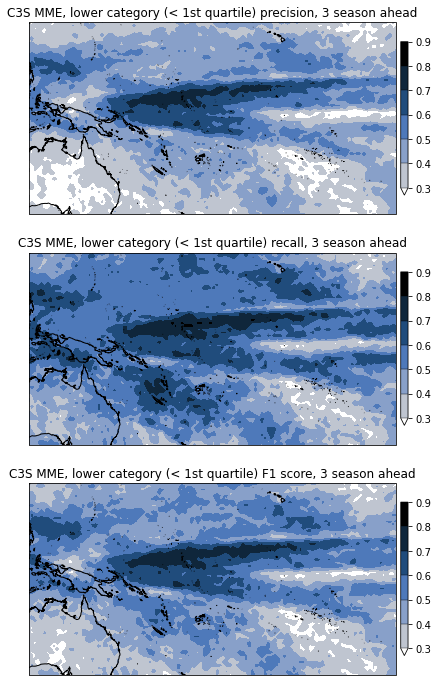

In [56]:
f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

axes = axes.flatten()

ax = axes[0]

precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) precision, {lead} {period_label} ahead")

ax = axes[1]

recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) recall, {lead} {period_label} ahead")

ax = axes[2]

F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) F1 score, {lead} {period_label} ahead")

# f.savefig(f'./{quantile}_{class_dict[class_value][0]}_precision_recall_F1score_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')

### ACCURACY

In [57]:
acc = dset['gcm'] == dset['verif']

In [58]:
acc = acc.sum('time') / len(acc.time)

In [59]:
cbar_kwargs.update(shrink=0.5)

In [60]:
cbar_kwargs

{'shrink': 0.5, 'orientation': 'vertical', 'drawedges': True, 'pad': 0.01}

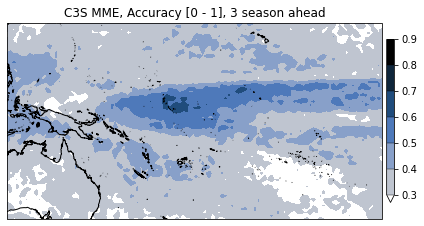

In [61]:
f, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

acc.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, Accuracy [0 - 1], {lead} {period_label} ahead")

f.savefig(f'./{quantile}_{class_dict[class_value][0]}_accuracy_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')